In [1]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl
import os

In [2]:
CLEAN_DATA_FOLDER = "clean_data"

In [3]:
ridership = pl.scan_csv(os.path.join(CLEAN_DATA_FOLDER, "ridership.csv"))

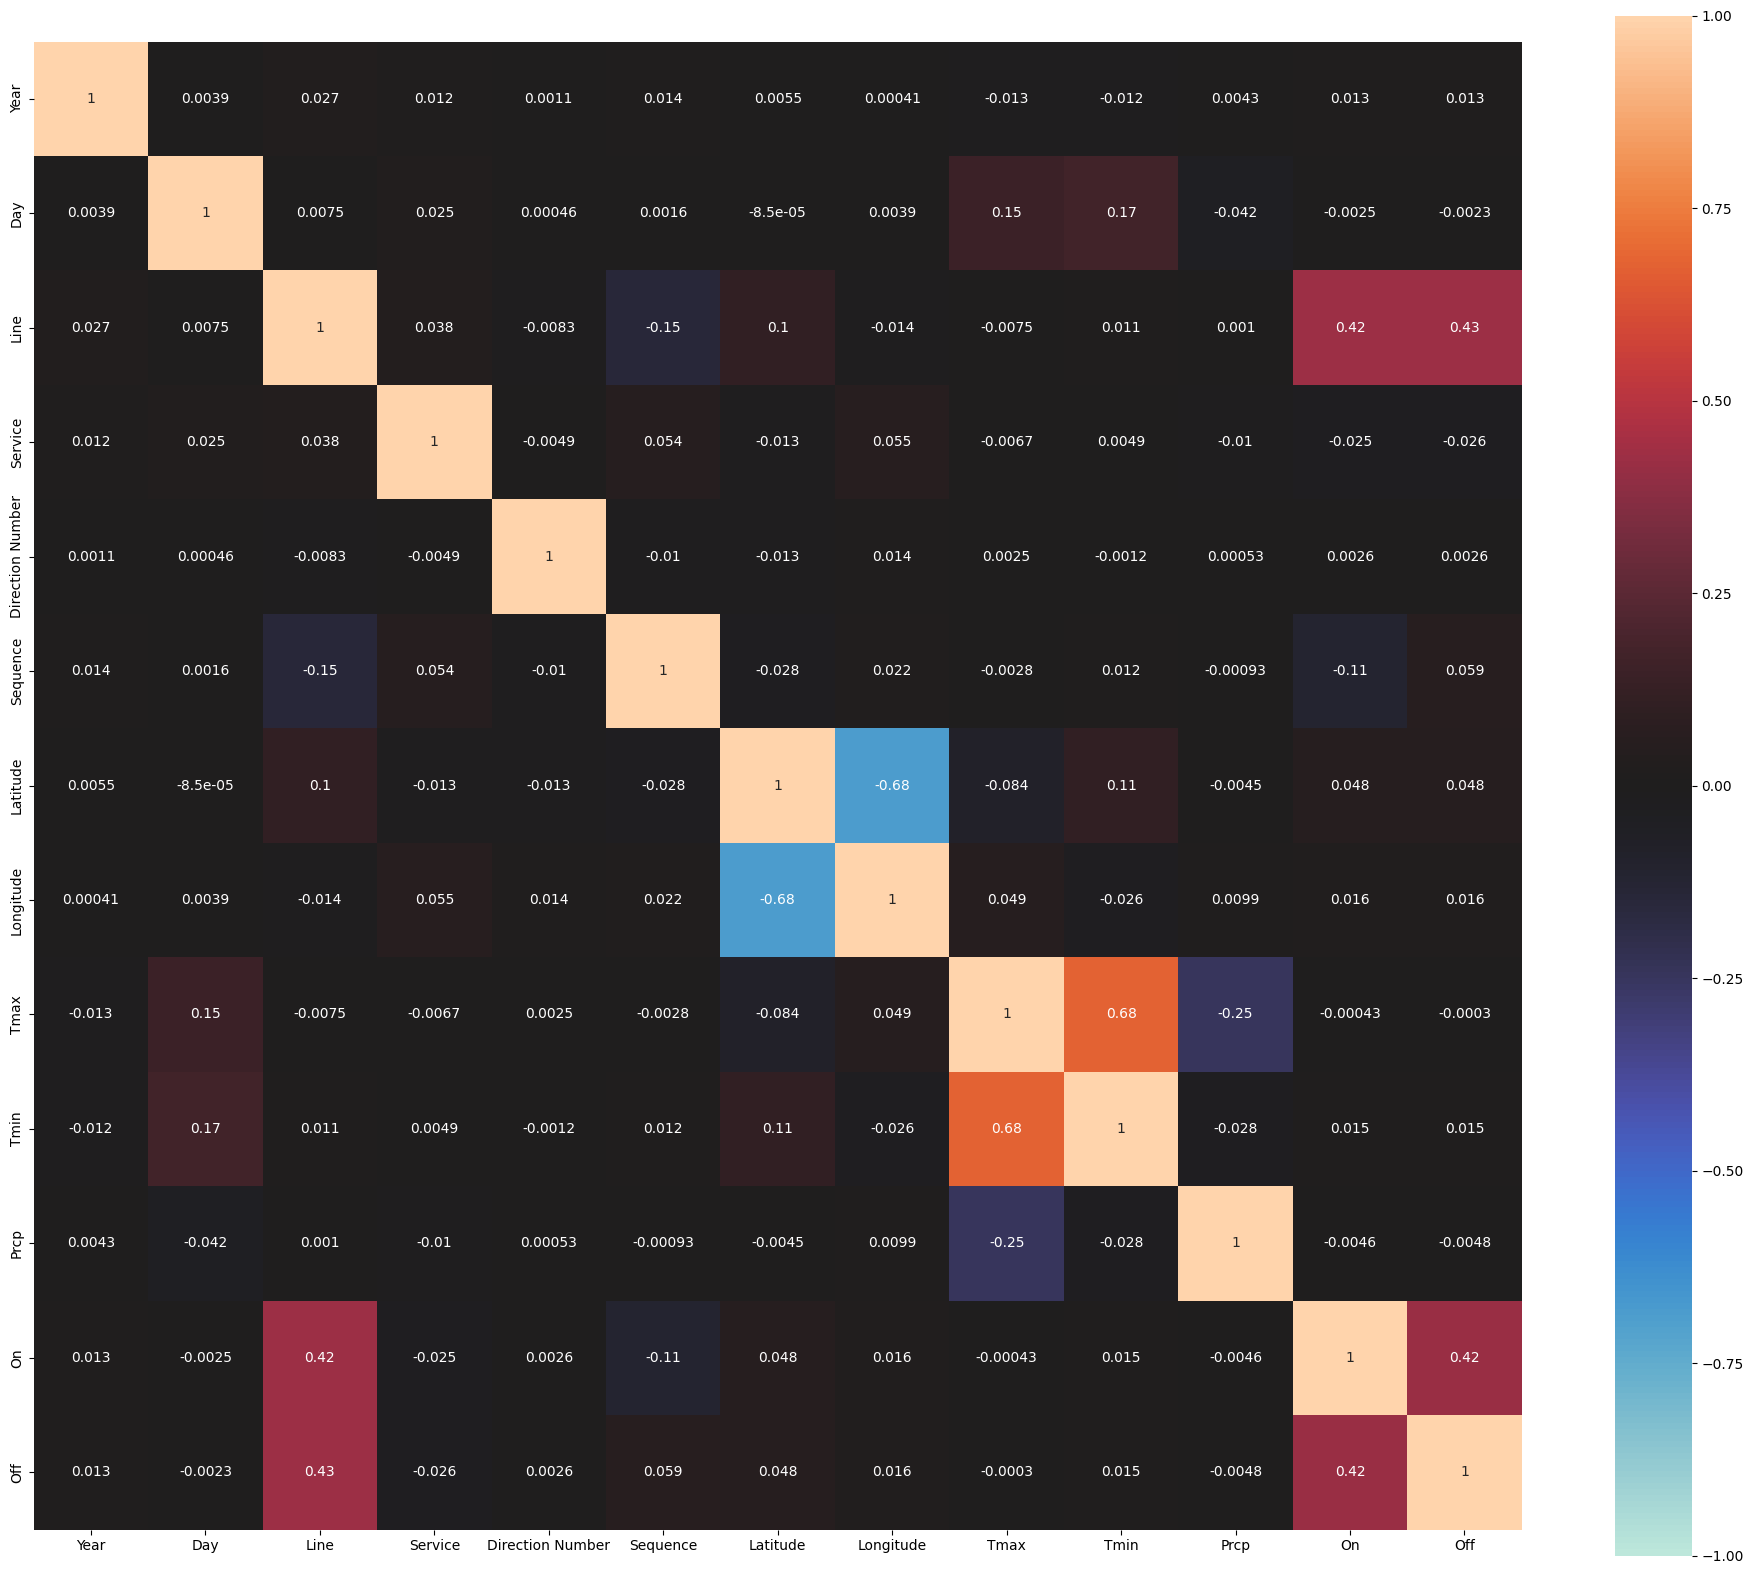

In [4]:
_, ax = plt.subplots(1, 1, figsize=(24, 20))
_ = sns.heatmap(
    ridership.collect().corr(),
    vmin=-1,
    vmax=1,
    annot=True,
    center=0,
    square=True,
    xticklabels=ridership.columns,
    yticklabels=ridership.columns,
    ax=ax,
)

In [5]:
ridership.describe()

statistic,Year,Day,Line,Service,Direction Number,Sequence,Latitude,Longitude,Tmax,Tmin,Prcp,On,Off
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",5.762272e6,5.762272e6,5.762272e6,5.762272e6,5.762272e6,5.762272e6,5.762272e6,5.762272e6,5.762272e6,5.762272e6,5.762272e6,5.762272e6,5.762272e6
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",2015.478546,181.982376,105.377811,1.33918,0.4977,29.852291,37.327758,-121.91899,22.61241,10.560228,0.93582,15.762428,15.784555
"""std""",1.114659,104.361806,183.09815,0.718619,0.499995,23.684394,0.080508,0.112748,5.573966,4.22705,4.346655,49.312612,48.634567
"""min""",2014.0,1.0,10.0,1.0,0.0,1.0,36.974922,-122.17364,-0.6,-7.2,0.0,0.0,0.0
"""25%""",2014.0,92.0,32.0,1.0,0.0,11.0,37.294266,-121.98368,18.3,7.8,0.0,1.0,1.0
"""50%""",2015.0,181.0,61.0,1.0,0.0,24.0,37.33429,-121.909096,22.2,11.1,0.0,3.0,4.0
"""75%""",2016.0,272.0,72.0,1.0,1.0,42.0,37.378197,-121.858,26.7,13.9,0.0,12.0,12.0
"""max""",2017.0,366.0,922.0,7.0,1.0,118.0,37.558388,-121.54903,42.2,27.2,89.7,3615.0,4189.0


In [6]:
def get_weekday(year, ordinal_day):
    date = datetime(year, 1, 1) + timedelta(days=ordinal_day - 1)
    return date.weekday()

def get_dayname(year, ordinal_day):
    date = datetime(year, 1, 1) + timedelta(days=ordinal_day - 1)
    return date.strftime("%A")

In [7]:
ridership = ridership.with_columns(
    pl.struct(["Year", "Day"])
    .map_elements(lambda x: get_weekday(x["Year"], x["Day"]))
    .alias("Weekday"),
    pl.struct(["Year", "Day"])
    .map_elements(lambda x: get_dayname(x["Year"], x["Day"]))
    .alias("Dayname"),
)

In [8]:
weekly_results = (
    ridership.group_by(["Weekday", "Dayname"])
    .agg([pl.col("On").sum(), pl.col("Off").sum()])
    .sort("Weekday")
    .select(["Dayname", "On", "Off"])
    .with_columns(pl.col("Dayname").alias("Weekday"))
    .collect()
    .to_pandas()
)

sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.


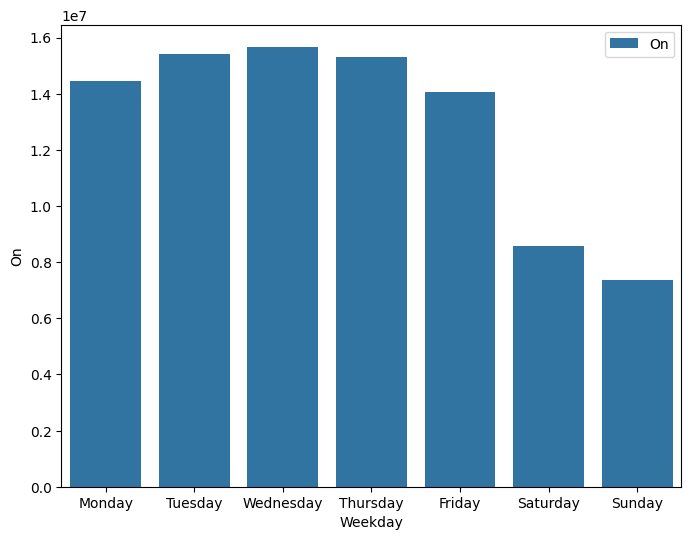

In [9]:
_, ax = plt.subplots(1, 1, figsize=(8, 6))
_ = sns.barplot(weekly_results, x="Weekday", y="On", ax=ax, label="On")

In [10]:
yearly_day_counts = (
    ridership.select(["Year", "Day", "On", "Off"])
    .group_by(["Year", "Day"])
    .agg([pl.col("On").sum(), pl.col("Off").sum()])
    .sort(["Year", "Day"])
    .collect()
    .to_pandas()
)

In [11]:
yearly_day_counts.head()

,Year,Day,On,Off
0,2014,1,25392,25385
1,2014,2,47599,47593
2,2014,3,53262,53264
3,2014,4,31795,31792
4,2014,5,31624,31613


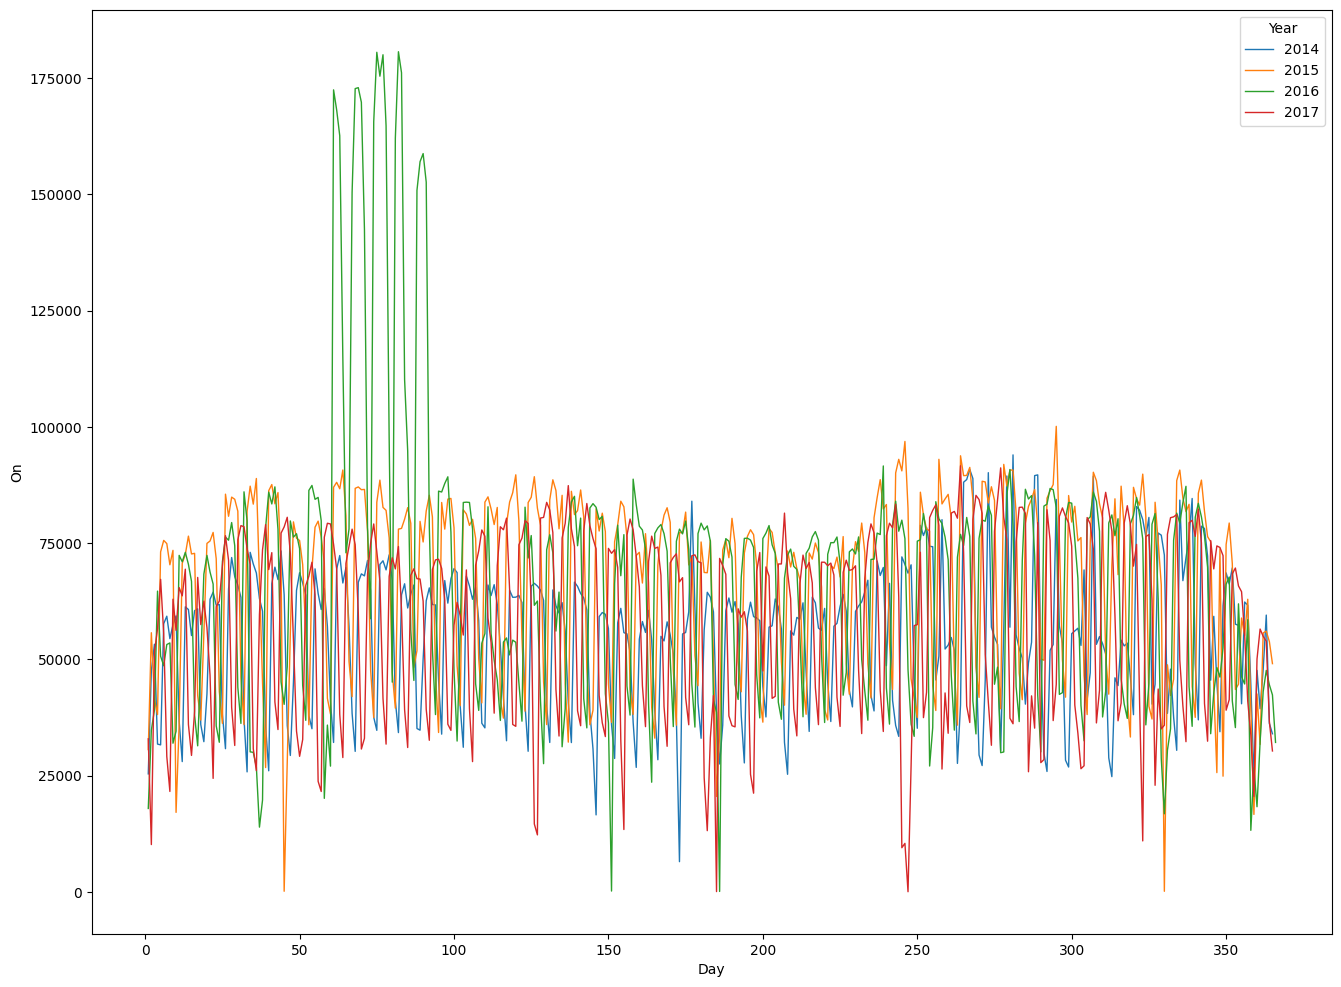

In [12]:
_, ax = plt.subplots(1, 1, figsize=(16, 12))
_ = sns.lineplot(yearly_day_counts, x="Day", y="On", hue="Year", palette=sns.color_palette("tab10", 4), linewidth=1, ax=ax)

/tmp/ipykernel_43302/1669655638.py:3: UserWarning: The palette list has more values (10) than needed (1), which may not be intended.
  _ = sns.lineplot(
/tmp/ipykernel_43302/1669655638.py:12: UserWarning: The palette list has more values (10) than needed (1), which may not be intended.
  _ = sns.lineplot(
/tmp/ipykernel_43302/1669655638.py:21: UserWarning: The palette list has more values (10) than needed (1), which may not be intended.
  _ = sns.lineplot(
/tmp/ipykernel_43302/1669655638.py:30: UserWarning: The palette list has more values (10) than needed (1), which may not be intended.
  _ = sns.lineplot(


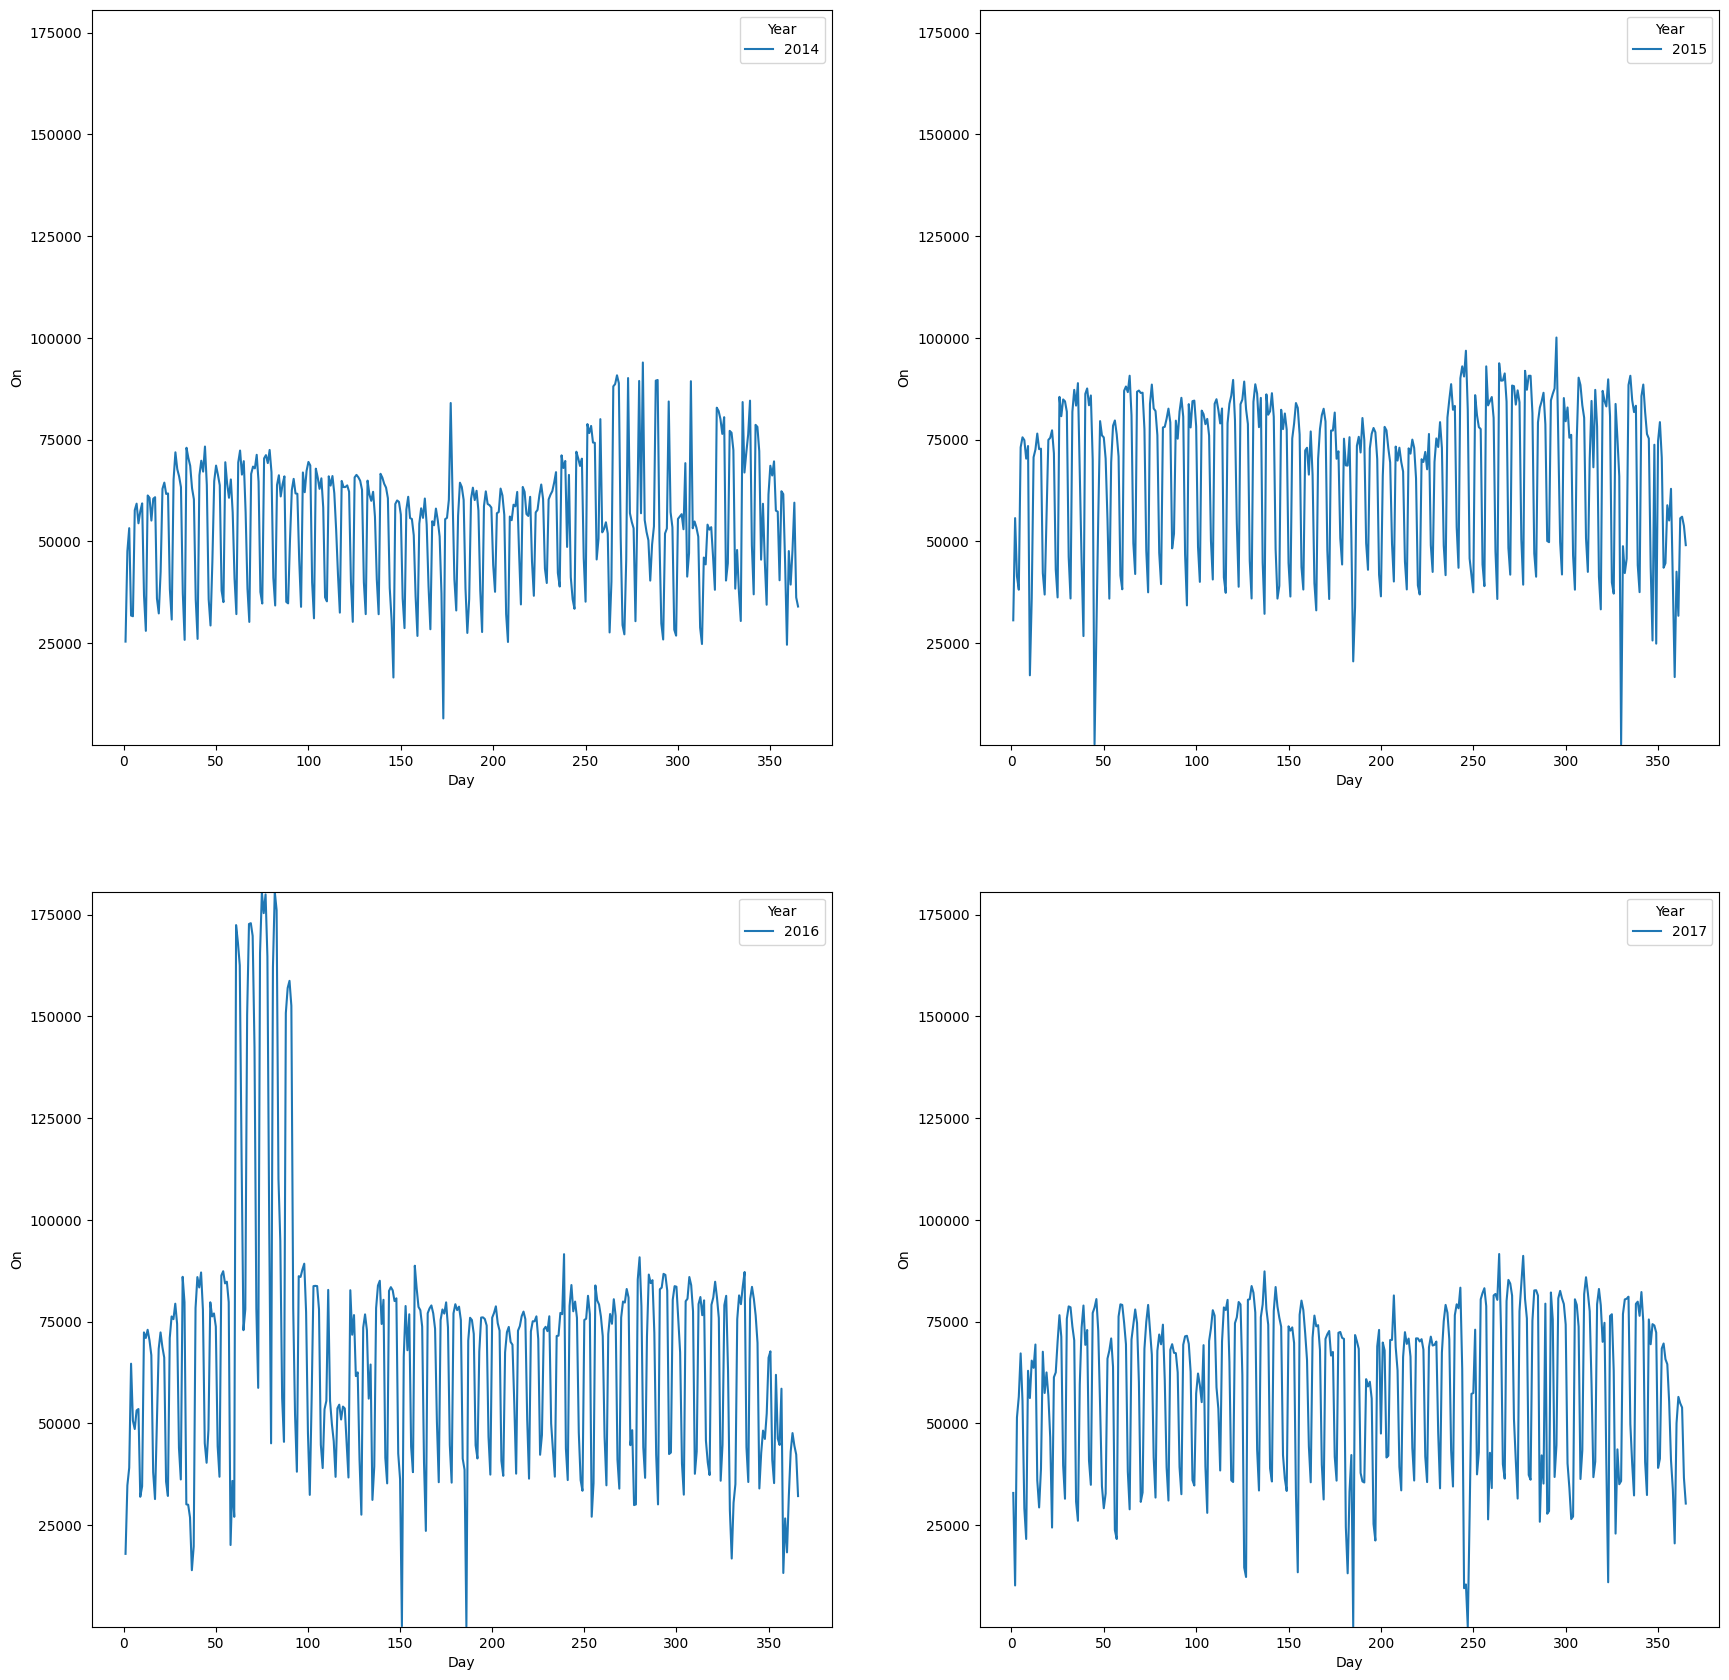

In [13]:
_, ax = plt.subplots(2, 2, figsize=(21, 21))
ax[0][0].set_ylim(55, 180640)
_ = sns.lineplot(
    yearly_day_counts[yearly_day_counts["Year"] == 2014],
    x="Day",
    y="On",
    hue="Year",
    palette=sns.color_palette("tab10"),
    ax=ax[0][0],
)
ax[0][1].set_ylim(55, 180640)
_ = sns.lineplot(
    yearly_day_counts[yearly_day_counts["Year"] == 2015],
    x="Day",
    y="On",
    hue="Year",
    palette=sns.color_palette("tab10"),
    ax=ax[0][1],
)
ax[1][0].set_ylim(55, 180640)
_ = sns.lineplot(
    yearly_day_counts[yearly_day_counts["Year"] == 2016],
    x="Day",
    y="On",
    hue="Year",
    palette=sns.color_palette("tab10"),
    ax=ax[1][0],
)
ax[1][1].set_ylim(55, 180640)
_ = sns.lineplot(
    yearly_day_counts[yearly_day_counts["Year"] == 2017],
    x="Day",
    y="On",
    hue="Year",
    palette=sns.color_palette("tab10"),
    ax=ax[1][1],
)